In [34]:
import os
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from astropy import units as u
from gatspy.periodic import LombScargleFast
from astroquery.jplhorizons import Horizons

In [105]:
#####-----CONSTANTS/stuff to check-----#####

xclude_lt_5sig = True
write_to_file_mikko = False
new_lc = False # Set to true if you have changed a param and are changing the lightcurve magnitude vals.
use_random_lc = True

limiting_rh = 3.5  # Value of rh beyond which to accept data points (minimise possibility of activity)
obj = '90000696'

beta = 0.059   # standard value of phase slope by which to correct apparent mags
real_period = 12.4041/24. # days
phase_to_real_period = False

In [73]:
# read in lightcurve data
home_path = os.path.expanduser('~/')
path_67p = home_path+'Documents/year1/shape_modelling/67p/'
file = path_67p+'67P_LCs_R.dat'
#####-----Remember to remove square brackets from file!!!!-----#####
data = pd.read_table(file, sep=' ')
data_table = data.to_numpy()

col_names = []
for col in data:
    col_names.append(col)
print('Column names for table:')
print(', '.join(col_names))

Column names for table:
mjd, mag, m_app, rh, delta, alpha, unc


In [74]:
# Read in LSST uncertainties from colours (DON"T USE THE ONES ABOVE, THESE ARE FROM FORS APPROX.):
colour_uncs = []
func = open(path_67p+'LSST_uncertainties_from_colours_ALL.txt', 'r')
lines = func.readlines()
for line in lines:
    data = line.split()
    colour_uncs.append(float(data[0]))

In [75]:
# reading in ecl long and lat

lon = []; lat = []
fecl = open(path_67p+'67p_ecl_lon_lat_ALL.txt', 'r')
eclines = fecl.readlines()
for line in eclines:
    data = line.split()
    lon.append(float(data[0]))
    lat.append(float(data[1]))

In [76]:
# Rename necessary columns to their respective column names:
mjd = data_table[:,0]
og_mag = data_table[:,1]
app_mag = data_table[:,2]
rh = data_table[:,3]
delta = data_table[:,4]
alpha = data_table[:,5]
#unc = data_table[:,-1]
unc = np.array(colour_uncs)


In [77]:
# Make a nice output file with all that^ in it so I don't keep forgetting what's what

# print params because I have a poor short term memory

if new_lc == True:
    fileWithAllData = open(path_67p+'67P_DATA_ALL_FINAL.txt', 'w+')
    fileWithAllData.write('mjd appMag unc rh delta alpha\n')
    for i in range(len(mjd)):
        fileWithAllData.write(f'{mjd[i]:.6f} {app_mag[i]:.4f} {unc[i]:.4f} {rh[i]:.6f} {delta[i]:.6f} {alpha[i]:.6f} {lon[i]:.4f} {lat[i]:.4f}\n')
    fileWithAllData.close()
    

In [78]:
# Now treating the lightcurve points as if they are real, apparent magnitudes obtained observationally
# Will correct for distance and for standard phase function with slope beta=0.04

# Absolute magnitude correction:

def convertToH0(m,b,a,r,d):
    H_r = m - (b*a) - (5.0*np.log10(r*d))
    return H_r

def correctForAlpha(h,b,a):
    H0 = h-(b*a)
    return H0

def convertToAppMag(H0,b,a,r,d):
    m = H0 + (5.0*np.log10(r*d)) + (b*a)
    return m

In [79]:
test_mags = []
for i,mag in enumerate(og_mag):
    newmag = correctForAlpha(mag, beta, alpha[i])
    test_mags.append(newmag)

In [130]:
if use_random_lc ==True:
    # Have option to use 5000 lightcurves;
    # randomly generate number between 1 and 5000
    lc_index = int(np.random.uniform(low=0, high=4999, size=None))
    random_data=

NameError: name 'random_data' is not defined

In [80]:
# Generate list of absolutely corrected magnitudes:
# Account here for minimum distance to the sun
# Also account for whether LSST will detect the object: 1/unc <5 undetected
magsPeriod = []; mjdPeriod = []; uncPeriod = []; rhPeriod=[]; deltaPeriod = []; alphaPeriod = []; lonPeriod=[]; latPeriod=[]

if xclude_lt_5sig==True:
    for i in range(len(app_mag)):
        if (rh[i]>=limiting_rh and 1./unc[i]>=5.):
            magsPeriod.append(convertToH0(app_mag[i], beta, alpha[i], rh[i], delta[i]))
            alphaPeriod.append(alpha[i])
            deltaPeriod.append(delta[i])
            mjdPeriod.append(mjd[i])
            uncPeriod.append(unc[i])
            rhPeriod.append(rh[i])
            latPeriod.append(lat[i])
            lonPeriod.append(lon[i])
    magsPeriod=np.array(magsPeriod)
    npoints = len(magsPeriod)
    print('No. values (SNR>5-sig) at heliocentric distance >%.1fau is %i out of possible %i'%(limiting_rh, npoints, len(app_mag)))
else:
    for i in range(len(app_mag)):
        if (rh[i]>=limiting_rh):
            magsPeriod.append(convertToH0(app_mag[i], beta, alpha[i], rh[i], delta[i]))
            alphaPeriod.append(alpha[i])
            deltaPeriod.append(delta[i])
            mjdPeriod.append(mjd[i])
            uncPeriod.append(unc[i])
            rhPeriod.append(rh[i])
            latPeriod.append(lat[i])
            lonPeriod.append(lon[i])
    npoints = len(magsPeriod)
    print('No. values (all) at heliocentric distance >%.1fau is %i out of possible %i'%(limiting_rh, npoints, len(app_mag)))
# Rescale points in mjdPeriod to=0
#mjdPeriod = np.around(mjdPeriod,decimals=6)#-mjdPeriod[0]

No. values (SNR>5-sig) at heliocentric distance >3.5au is 430 out of possible 678


In [81]:
magsPeriod

array([15.54812812, 15.39457084, 15.45562522, 15.45564443, 15.37240307,
       15.3721055 , 15.37538285, 15.3766871 , 15.53045651, 15.47089487,
       15.2255576 , 15.26953745, 15.26249995, 15.46022813, 15.40485913,
       15.39659185, 15.38069295, 15.37960015, 15.42418565, 15.55695695,
       15.63441989, 15.61637845, 15.22392457, 15.22639646, 15.24129449,
       15.28556644, 15.33706021, 15.33596469, 15.27883155, 15.27703609,
       15.57878787, 15.58079267, 15.57588867, 15.57509293, 15.44564805,
       15.4125525 , 15.53362915, 15.49773289, 15.32493971, 15.24252086,
       15.33119377, 15.44988686, 15.61084741, 15.56538901, 15.53460805,
       15.25279417, 15.2972241 , 15.58382015, 15.54616763, 15.48734625,
       15.486689  , 15.48530072, 15.45032566, 15.44743808, 15.38515018,
       15.38008094, 15.40231062, 15.35573824, 15.41240567, 15.37124131,
       15.3705468 , 15.31548365, 15.44648062, 15.44818618, 15.37875109,
       15.38284937, 15.51452969, 15.47692957, 15.46380536, 15.43

In [82]:
appPeriod = []
for i in range(len(magsPeriod)):
    m = convertToAppMag(magsPeriod[i], beta, alphaPeriod[i], rhPeriod[i], deltaPeriod[i])
    #print(f'{m:.4f}')
    appPeriod.append(m)
print(limiting_rh)

3.5


In [83]:
# Make final text file containing final dataset - for use with MC lightcurve generator
if new_lc==True:
    fileWithAllData = open(f'{path_67p}67P_DATA_5SIG_{limiting_rh}AU_FINAL.txt', 'w+')
    fileWithAllData.write('mjd appMag unc rh delta alpha\n')
    for i in range(len(mjdPeriod)):
        fileWithAllData.write(f'{mjdPeriod[i]:.6f} {appPeriod[i]:.4f} {uncPeriod[i]:.4f} {rhPeriod[i]:.6f} {deltaPeriod[i]:.6f} {alphaPeriod[i]:.6f} {lonPeriod[i]:.4f} {latPeriod[i]:.4f}\n')
    fileWithAllData.close()

In [84]:
for i in range(10):
    print('%.6f %.4f'%(mjdPeriod[i],magsPeriod[i]))

2459957.799644 15.5481
2459964.820003 15.3946
2459966.849076 15.4556
2459966.853635 15.4556
2459970.808050 15.3724
2459970.808461 15.3721
2459970.823103 15.3754
2459970.823931 15.3767
2459972.797099 15.5305
2459973.855214 15.4709


In [85]:
# Create Mikko-format file using the restricted data as defined above for use in shape modelling
# Instead of re-reading in xyz vectors again, read in lines from existing Mikko file
# Cross check with MJDs to only select vals that obey 5-sig & distance criteria
# Write these lines to a new file

mjds_test = []
count_points = 0
filenamestr = path_67p+'67P_LC_NU_5sig_'+str(limiting_rh)+'_au_beta_'+str(beta)[-3:]+'.dat'
print(filenamestr)

if (write_to_file_mikko==True and beta==0.059):
    
    #file_open = open(filenamestr, 'w+')
    mikko_file_all = open(path_67p+'67P_LC_NU.dat')
    lines_all = mikko_file_all.readlines()
    filteredLines = []
    
    for line in lines_all[1:]:
        data=line.split()
        mjd_test_val = float(data[0])
        mjds_test.append(mjd_test_val)
        if mjd_test_val in np.around(np.array(mjdPeriod),6) or len(str(mjd_test_val))<6:
            filteredLines.append(line)
    sameday = []
    counter = 0
    for i in range(len(filteredLines)):
        if (len(filteredLines[i])<6 and len(filteredLines[i+1])<6):
            pass
        elif (len(filteredLines[i])<6 and len(filteredLines[i+1])>=6):
            #file_open.write('%i 1\n'%len(sameday))
            count_points=count_points+len(sameday)
            print(f'{len(sameday)} {count_points} 1')
            for line in sameday:
                #file_open.write(line)
                print(line)
            sameday = []
            counter = counter+1
        else:
            sameday.append(filteredLines[i])

elif (write_to_file_mikko==False and beta!=0.059):
    print('Yeet')
    mikko_file_all = open(path_67p+'67P_LC_NU.dat')
    lines_all = mikko_file_all.readlines()
    filteredLines = []
    mikko_file_all.close()
    
    
    # Add the final line of the file (not included in method shown above)
    #file_open.write('1 1\n')
    #file_open.write(filteredLines[-1])
    #print('1 1')
    #print(filteredLines[-1])
    #print(counter, count_points+1)
    #file_open.close()   
    #print(counter_to_subtract, counter_check)

/Users/s1523386/Documents/year1/shape_modelling/67p/67P_LC_NU_5sig_3.5_au_beta_059.dat


In [86]:
if write_to_file_mikko==True:
    filteredLines_Mjds = []
    for entry in filteredLines:
        if len(entry) > 10:
            filteredLines_Mjds.append(entry)

In [87]:
if write_to_file_mikko==True:
    for i in range(len(mjdPeriod)):
        print(filteredLines_Mjds[i][0:15],'%.6f'%mjdPeriod[i])

In [88]:
#print(mjdPeriod[8],magsPeriod[8], 1./uncPeriod[8])

In [89]:
#uncPeriod=np.array(uncPeriod)*0.5

In [90]:
# Import perihelion time for 67P
peri_mjd = []
comet = Horizons(id=obj, location='500@0', epochs=mjdPeriod[0])
els = comet.elements(refplane='earth')
peri_mjd.append(float(els['Tp_jd']))
per = float(els['P'])
print(peri_mjd, per/365.)

[2459519.114469609] 6.469293499514918


In [91]:
# Find next point one orbital period along to draw lines on the plot

mjd_newepoch = mjdPeriod[0]+per

for i in range(len(mjdPeriod)):
    if mjdPeriod[i]>=mjd_newepoch:
        index_newepoch = i
        break

In [92]:
comet = Horizons(id=obj, location='500@0', epochs=mjdPeriod[index_newepoch])
els = comet.elements(refplane='earth')
peri_mjd.append(float(els['Tp_jd']))
print(peri_mjd)

[2459519.114469609, 2461872.093140016]


In [93]:
np.around(mjdPeriod,6)

array([2459957.799644, 2459964.820003, 2459966.849076, 2459966.853635,
       2459970.80805 , 2459970.808461, 2459970.823103, 2459970.823931,
       2459972.797099, 2459973.855214, 2459977.817678, 2459978.808516,
       2459979.844439, 2459980.778005, 2459984.742117, 2459984.745833,
       2459984.757426, 2459984.75825 , 2459984.802372, 2459990.817626,
       2459990.833676, 2459990.849402, 2459991.754955, 2459991.771518,
       2459992.816256, 2459992.832497, 2459994.812072, 2459994.812487,
       2459994.827634, 2459994.828052, 2459997.770978, 2459997.771392,
       2459997.788245, 2459997.788659, 2460002.809682, 2460002.826049,
       2460003.805077, 2460003.82115 , 2460006.703052, 2460006.732165,
       2460008.768007, 2460009.738086, 2460017.724754, 2460017.741724,
       2460017.757072, 2460019.69161 , 2460019.707642, 2460025.680273,
       2460025.70428 , 2460025.723492, 2460029.668569, 2460029.669403,
       2460029.685045, 2460029.685884, 2460029.721573, 2460029.737676,
      

In [94]:
# LC 238 mjd: 2462589.691307

index9 = np.where(np.around(mjdPeriod,6)==2462589.691307)[0][0]

print(mjdPeriod[index9], magsPeriod[index9])

2462589.691307 15.492439805381867


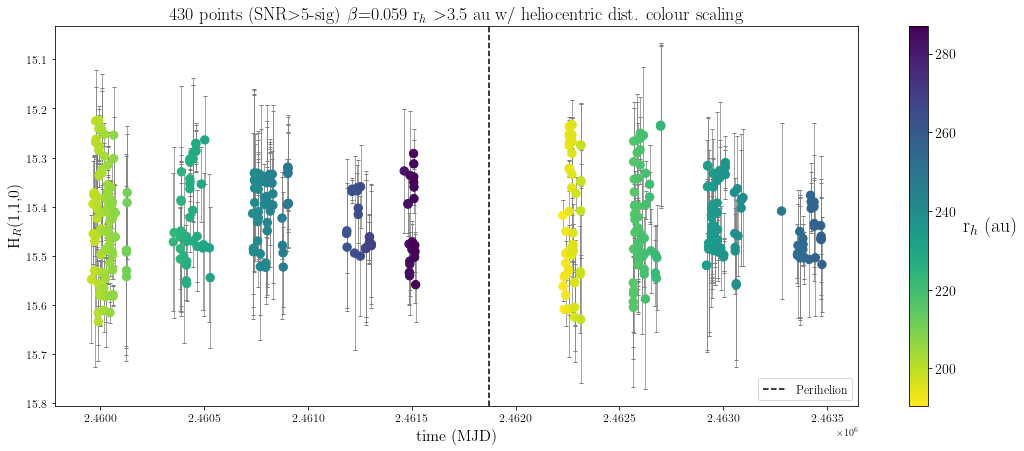

In [95]:
# Have a look at data
labels=16; ticks=12; titles=18
plt.figure(figsize=(18,7))
#for apparition in peri_mjd:
v = plt.axvline(peri_mjd[-1], linestyle='--', color='black', label = 'Perihelion')
plt.scatter(mjdPeriod, magsPeriod, c=lonPeriod, cmap='viridis_r', s=70, zorder=2)
plt.errorbar(mjdPeriod, magsPeriod, yerr=uncPeriod, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('time (MJD)', fontsize=labels)
plt.ylabel('H$_R$(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.gca().invert_yaxis()

if xclude_lt_5sig == True:
    titlestr = r"%s points (SNR\textgreater5-sig) $\beta$=%.3f r$_h$ \textgreater %.1f au w/ heliocentric dist. colour scaling"%(str(npoints), beta, limiting_rh)
else:
    titlestr = r"%s points (no SNR limit) r$_h$ \textgreater %.1f au w/ heliocentric dist. colour scaling"%(str(npoints), limiting_rh)

# Set colourbar to be actually readable and useful
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label(r' r$_h$ (au)', rotation=0,  labelpad=35, fontsize=20)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_yticklabels(['3.6', '4.0', '4.5', '5.0', '5.5'])
plt.title(titlestr, fontsize=titles)
plt.legend(loc=4, fontsize=ticks)
plt.show()
savenamestr = path_67p+'paper_pics/67p_lc_5sig_%sau'%(int(limiting_rh))
#plt.savefig(savenamestr)
#fig, ax = plt.subplots(figsize=(16, 6))
#ax.errorbar(mjdPeriod, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0)
#ax.set(xlabel='time (MJD)', ylabel='magnitude', title='67P LSST magnitudes')
#ax.invert_yaxis()

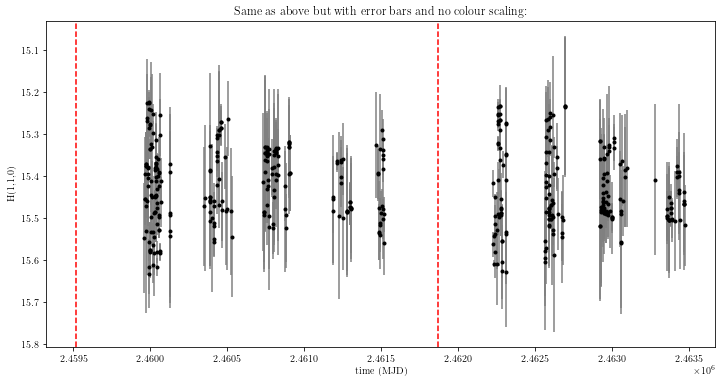

In [96]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(mjdPeriod, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0)
for apparition in peri_mjd:
    v = plt.axvline(apparition, linestyle='--', color='red')
ax.set(xlabel='time (MJD)', ylabel='H(1,1,0)', title='Same as above but with error bars and no colour scaling:')
ax.invert_yaxis()

In [97]:
# period range to sample:

min_prot=0.1#*u.day # days
max_prot=2.#*u.day # days
Nsample = 100000
# Define frequency range:
freq = np.linspace(1./max_prot, 1./min_prot, Nsample)

In [98]:
 # Astropy periodogram implementation:
power_ap = LombScargle(mjdPeriod, magsPeriod, uncPeriod).power(freq, method='fast')

best_frequency_ap = freq[np.argmax(power_ap)]
best_period_ap = 1./best_frequency_ap
print("Best period (astropy) = {0:.4f}h".format((best_period_ap)*24.))
periods_ap = 1./freq

Best period (astropy) = 8.3713h


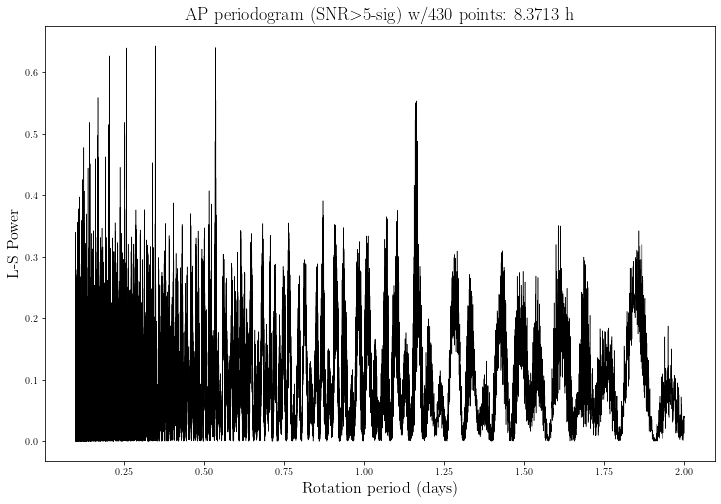

In [99]:
plt.figure(figsize=(12,8))
plt.plot(periods_ap, power_ap,color='k',linewidth=0.5)
if xclude_lt_5sig==True:
    titlestr=r'AP periodogram (SNR\textgreater 5-sig) w/%i points: %.4f h'%(npoints, (best_period_ap)*24.)
else:
    titlestr='AP periodogram (no SNR limit) w/%i points: %.4f h'%(npoints, (best_period_ap)*24.)
plt.title(titlestr, fontsize=titles)

plt.xlabel('Rotation period (days)', fontsize=labels)
plt.ylabel('L-S Power', fontsize=labels)

#plt.show()
savenamestr = path_67p+'paper_pics/periodogram_AP_5sig_%sau'%(int(limiting_rh))+'_beta_'+str(beta)[-2:]
plt.savefig(savenamestr)
#print(savenamestr)

In [100]:
# Phase the data to the best period
multiplier = 2.
mjdPeriod=np.array(mjdPeriod)

In [101]:
if phase_to_real_period==True:
    final_period_ap = real_period
    phase_ap = mjdPeriod/final_period_ap % 1
    print('Using real period %.4f'%(final_period_ap*24.))
else:
    final_period_ap = multiplier*best_period_ap
    phase_ap = mjdPeriod/final_period_ap % 1
    print('Phase to %.1fx best-fit LS (astropy) period %.4fh = %.4fh'%(multiplier, best_period_ap*24., multiplier*best_period_ap*24.))

Phase to 2.0x best-fit LS (astropy) period 8.3713h = 16.7425h


In [102]:
phase_real_period = mjdPeriod/real_period % 1

for i in range(len(phase_real_period)):
    print('%.4f, %.4f, %.4f, %.4f'%((mjdPeriod[i]-mjdPeriod[0])/(real_period), (mjdPeriod[i]-mjdPeriod[0])/(2*best_period_ap), phase_ap[i], phase_real_period[i]))

0.0000, 0.0000, 0.3703, 0.8942
13.5833, 10.0635, 0.4338, 0.4775
17.5092, 12.9721, 0.3425, 0.4035
17.5181, 12.9787, 0.3490, 0.4123
25.1692, 18.6472, 0.0176, 0.0635
25.1700, 18.6478, 0.0181, 0.0643
25.1984, 18.6688, 0.0391, 0.0926
25.2000, 18.6700, 0.0403, 0.0942
29.0177, 21.4985, 0.8688, 0.9120
31.0650, 23.0152, 0.3856, 0.9593
38.7318, 28.6953, 0.0657, 0.6260
40.6489, 30.1157, 0.4860, 0.5431
42.6532, 31.6006, 0.9710, 0.5475
44.4595, 32.9389, 0.3092, 0.3538
52.1295, 38.6213, 0.9917, 0.0237
52.1367, 38.6267, 0.9970, 0.0309
52.1591, 38.6433, 0.0136, 0.0533
52.1607, 38.6445, 0.0148, 0.0549
52.2461, 38.7077, 0.0781, 0.1403
63.8846, 47.3304, 0.7008, 0.7789
63.9157, 47.3534, 0.7238, 0.8099
63.9461, 47.3760, 0.7463, 0.8404
65.6982, 48.6741, 0.0444, 0.5925
65.7303, 48.6978, 0.0682, 0.6245
67.7517, 50.1954, 0.5658, 0.6459
67.7831, 50.2187, 0.5890, 0.6773
71.6133, 53.0564, 0.4267, 0.5075
71.6141, 53.0570, 0.4273, 0.5083
71.6434, 53.0787, 0.4490, 0.5376
71.6442, 53.0793, 0.4496, 0.5384
77.3383, 57.

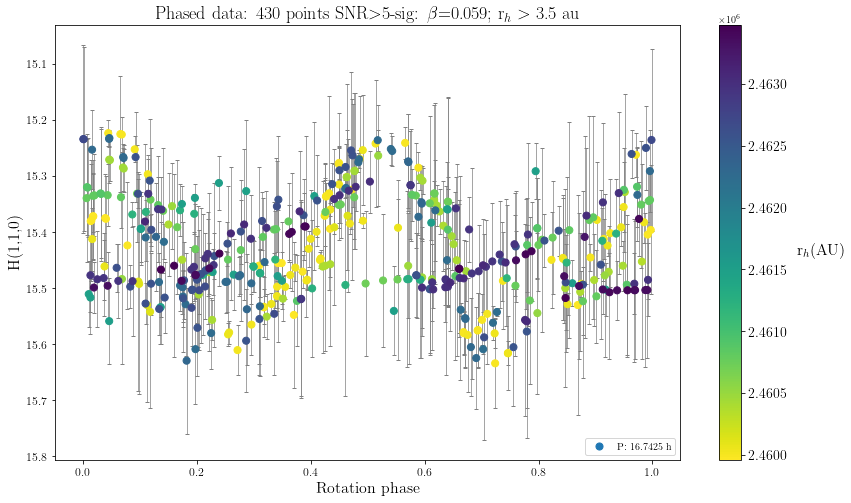

In [103]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].plot(periods_ap, power_ap)
#ax[0].set(xlabel='Period (days)', ylabel='Lomb-Scargle Power (AP)', title='Lomb-Scargle Periodogram (AP)')

#ax[1].errorbar(phase_ap, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0, label='P: %.4f h'%(multiplier*24.*best_period_ap))
#ax[1].set(xlabel='phase', ylabel='magnitude', title='Phased Data (AP)')
#ax[1].invert_yaxis()
#ax[1].legend(loc=4)
#plt.show()

plt.figure(figsize=(14,8))
plt.scatter(phase_ap, magsPeriod, c=mjdPeriod, cmap='viridis_r', s=50, label='P: %.4f h'%(24.*final_period_ap), zorder=2)
plt.errorbar(phase_ap, magsPeriod, yerr=uncPeriod, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('Rotation phase', fontsize=labels);plt.ylabel('H(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks); plt.yticks(fontsize=ticks)
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label('r$_h$(AU)', labelpad=35, rotation=0, fontsize=labels)
cbar.ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()
if xclude_lt_5sig==True:
    titlestr=fr"Phased data: {npoints} points SNR$>$5-sig: $\beta$={beta}; r$_h >$ {limiting_rh} au"
else:
    titlestr=fr"Phased data: {npoints} points (no limiting SNR): $\beta$={beta}; r$_h >$ {limiting_rh} au"

plt.title(titlestr, fontsize=titles)
plt.legend(loc=4)
#plt.set(xlabel='phase', ylabel='magnitude', title='Phased Data')
plt.show()

In [165]:
# Trialling different periodogram methods:
#  i) gatspy LombScargleFast
# ii) Astropy

In [30]:
#weird_points = []
#for i,val in enumerate(magsPeriod):
#    if val>15.77 and 0.45<phase_gp[i]<0.7:
#        print(val, phase_gp[i], mjdPeriod[i],i)
#        weird_points.append(mjdPeriod[i])
#max(weird_points)-min(weird_points)

In [31]:
# Gatspyperiodogram implementation:

"""
# i)

model_gp = LombScargleFast().fit(t_days, mags)
model_gp.optimizer.set(period_range=(min_prot,max_prot))
best_period_gp = model_gp.best_period
print("Best period (gatspy) = {0:.6f}h".format((best_period_gp)*24.))

periods_gp = np.linspace(min_prot, max_prot, Nsample)
power_gp = model_gp.periodogram(periods_gp)

#index_max_gp = np.where(power_gp==max(power_gp))
print(periods_gp[np.argmax(power_gp)]*24.)

plt.figure(figsize=(14,7))
plt.plot(periods_gp, power_gp,color='k',linewidth=0.5)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.xlabel('Period (d)', fontsize=labels)
plt.ylabel('LS power', fontsize=labels)
plt.title('Gatspy periodogram %i LC points: %.4f h'%(npoints, best_period_gp*24.), fontsize=titles)
plt.show()

# Phase the data to the best period
multiplier = 1.

if phase_to_real_period==True:
    final_period_gp = real_period
    phase_gp = t_days/final_period_gp % 1
    print('Using real period %.4f'%(real_period*24.))
else:
    final_period_gp = multiplier*best_period_gp
    phase_gp = t_days/final_period_gp % 1
    print('Phase to %.1fx best-fit LS (gatspy) period %.4f h'%(multiplier, best_period_gp*24.))
    
#fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].plot(periods_gp, power_gp)
#ax[0].set(xlabel='Period (days)', ylabel='Lomb-Scargle Power', title='Lomb-Scargle Periodogram')

#ax[1].errorbar(phase_gp, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0, label='P: %.4f h'%(real_period*24.))#multiplier*24.*best_period_gp))
#ax[1].set(xlabel='phase', ylabel='magnitude', title='Phased Data')
#ax[1].invert_yaxis()
#ax[1].legend(loc=4)
#plt.show()

plt.figure(figsize=(14,8))
plt.scatter(phase_gp, magsPeriod, c=rhPeriod, cmap='viridis_r', s=50, label='P: %.4f h'%(24.*final_period_gp), zorder=2)
#plt.errorbar(phase_gp, magsPeriod, yerr=mags_unc, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('Rotational phase', fontsize=labels);plt.ylabel('H$_R$(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks); plt.yticks(fontsize=ticks)
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
#cbar.set_label('r$_h$(AU)', rotation=0, labelpad=35, fontsize=20)
cbar.ax.tick_params(labelsize=14)
plt.title('Phased data (GP): r$_h >$ %.1f au'%limiting_rh, fontsize=titles)
plt.gca().invert_yaxis()
plt.legend(loc=4)
#plt.set(xlabel='phase', ylabel='magnitude', title='Phased Data')
plt.show()
#plt.savefig(data_dir+'paper_pics/'+'phased_lc_rh_%s_gp_P_%.4f_colorMJD.png'%(str(limiting_rh), 24.*final_period_gp), format='png', dpi=200)
""";



In [32]:
aspect_angles = []
afile = open(path_67p+'67p_aspect_326.dat')
lines = afile.readlines()
for line in lines:
    aspect_angles.append(float(line))

In [33]:
plt.figure(figsize=(14,8))
plt.scatter(mjd_aspect, aspect_angles,s=20)
for apparition in peri_mjd:
    v = plt.axvline(apparition, linestyle='--', color='grey')
plt.xlabel('MJD', fontsize=labels);plt.ylabel('Aspect angle (deg)', fontsize=labels)

plt.show()

NameError: name 'mjd_aspect' is not defined

<Figure size 1008x576 with 0 Axes>

In [ ]:
lcmikko[-5:]

In [ ]:
len(rh_aspect)

In [ ]:
mjd

In [ ]:
counter=0
for i in range(len(lcmikko)):
    if lcmikko[i] in mjd:
        counter=counter+1
        print(counter,i, lcmikko[i])

In [ ]:
max(rh)

In [ ]:
type(npoints)

In [ ]:
print('%i'%npoints)

In [ ]:
np.around(np.array(mjdPeriod),6)

In [ ]:
mjdPeriod[-1]